In [1]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU. Using CPU.")

GPU is available!
Using device: Tesla T4


In [3]:
!pip install gdown --quiet
!gdown '1nizYa2JQHOj4Wv35DjLfeypUY5dJfE8E'

Downloading...
From (original): https://drive.google.com/uc?id=1nizYa2JQHOj4Wv35DjLfeypUY5dJfE8E
From (redirected): https://drive.google.com/uc?id=1nizYa2JQHOj4Wv35DjLfeypUY5dJfE8E&confirm=t&uuid=cdd33271-8cd0-425f-985f-dc681e1299ae
To: /content/final_data_with_summarization_FinalTesting1.csv
100% 137M/137M [00:01<00:00, 108MB/s]


# 1. Loading the Data

In [4]:
df = pd.read_csv(r"final_data_with_summarization_FinalTesting1.csv")

In [5]:
df["input"] = df["text_summary"].fillna(df["text"])

In [6]:
df["input"].isnull().sum()

np.int64(0)

In [7]:
X = df["title"].fillna("") + " " + df["input"].fillna("")

In [8]:
Y = df["label"]

In [9]:
X_test = X.values
y_test = Y.values

# 2. Preparing Data Loaders and Model

We use the [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) embedding model from huggingface and fine tune it.

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels.astype("float32")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [ ]:
test_dataset = TextDataset(X_test, y_test)

In [ ]:
batch_size = 1024

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

In [ ]:
class EmbeddingClassifier(nn.Module):
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        super(EmbeddingClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.classifier = nn.Sequential(
            nn.Linear(384, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 2)
        )

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
            input_mask_expanded.sum(1), min=1e-9
        )

    def forward(self, input_texts):
        encoded = self.tokenizer(
            input_texts,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(next(self.parameters()).device)

        model_output = self.encoder(**encoded)
        sentence_embeddings = self.mean_pooling(model_output, encoded['attention_mask'])
        logits = self.classifier(sentence_embeddings)
        return logits  # ouput shape: [batchsize, 2]

In [ ]:
NN_Model = EmbeddingClassifier()
NN_Model.to(device)

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

EmbeddingClassifier(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elem

In [ ]:
NN_Model.load_state_dict(torch.load('EmbeddingClassifier_FineTuned.pth'))

<All keys matched successfully>

# 3. Helper Functions

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
def perform_deep_test_analysis(y_test, test_preds: np.array, test_preds_proba: np.array, model_name: str) -> None:
    """"
    This function takes in a model object and model name, and performs a deep analysis on the model's performance on the test set.
    It prints classification report, confusion matrix, ROC AUC score and plots the ROC curve.
    """
    cm = confusion_matrix(y_test, test_preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n")
    print("FOR TESTING SET: ")
    print(classification_report(y_test, test_preds))
    print("\n")

    print(f"ROC AUC Score: {roc_auc_score(y_test, test_preds_proba):.2%}")
    print("\n")

    fpr, tpr, _ = roc_curve(y_test, test_preds_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
def make_predictions_using_NN(model, data_loader):
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for xb, labels in tqdm(data_loader):
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    return all_preds, all_probs

# 4. Models

## 4.1 Finetuned EmbeddingClassifier

100%|██████████| 44/44 [04:27<00:00,  6.07s/it]

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     21417
           1       1.00      0.98      0.99     23481

    accuracy                           0.99     44898
   macro avg       0.99      0.99      0.99     44898
weighted avg       0.99      0.99      0.99     44898



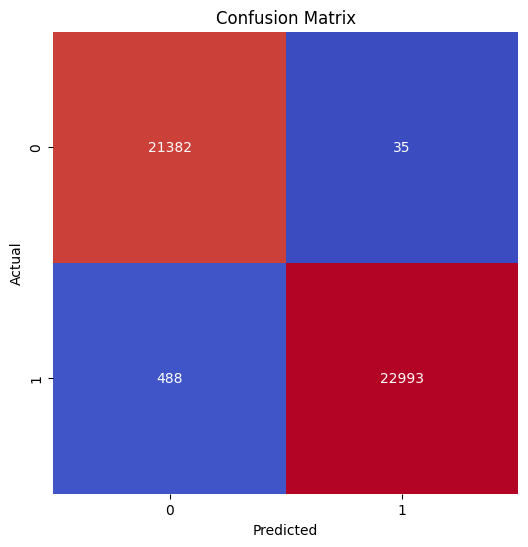



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     21417
           1       1.00      0.98      0.99     23481

    accuracy                           0.99     44898
   macro avg       0.99      0.99      0.99     44898
weighted avg       0.99      0.99      0.99     44898



ROC AUC Score: 99.96%




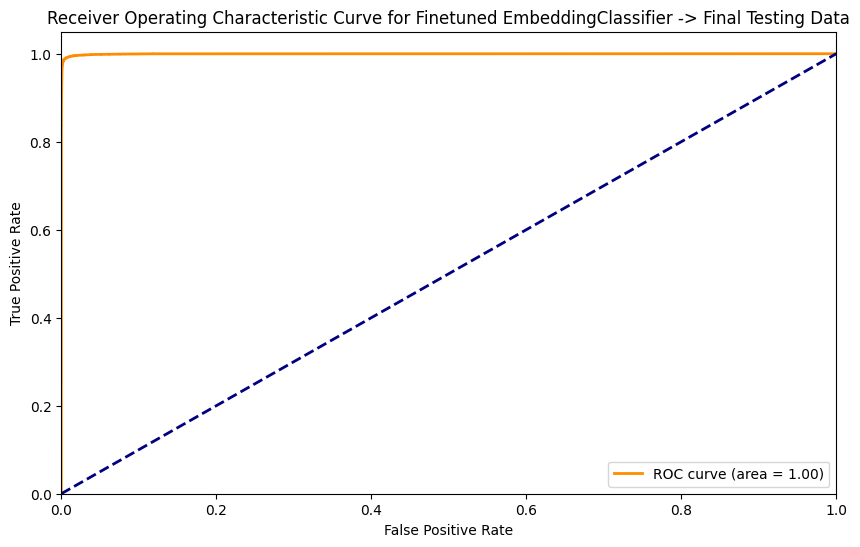

In [ ]:
test_preds, test_probs = make_predictions_using_NN(NN_Model, test_loader)
print(classification_report(y_test, test_preds))
perform_deep_test_analysis(y_test, test_preds, test_probs[:, 1], "Finetuned EmbeddingClassifier -> Final Testing Data")

## 4.2 XGBoost

In [ ]:
model_pretrained = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import pickle

with open('XGBoost_Model.pkl', 'rb') as file:
    XGBoost_Model = pickle.load(file)

In [ ]:
XGBoost_Model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping=30,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
def batch_encode(text_list, model, batch_size=2048*3):
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch = text_list[i:i+batch_size]
        batch_emb = model.encode(batch)
        embeddings.extend(batch_emb)
    return embeddings

100%|██████████| 8/8 [01:56<00:00, 14.51s/it]


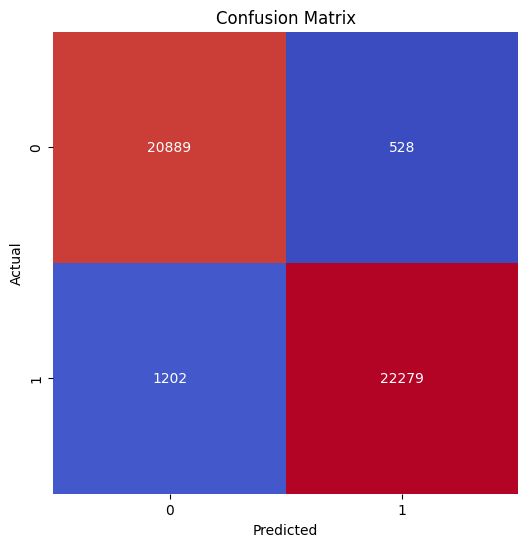



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     21417
           1       0.98      0.95      0.96     23481

    accuracy                           0.96     44898
   macro avg       0.96      0.96      0.96     44898
weighted avg       0.96      0.96      0.96     44898



ROC AUC Score: 99.41%




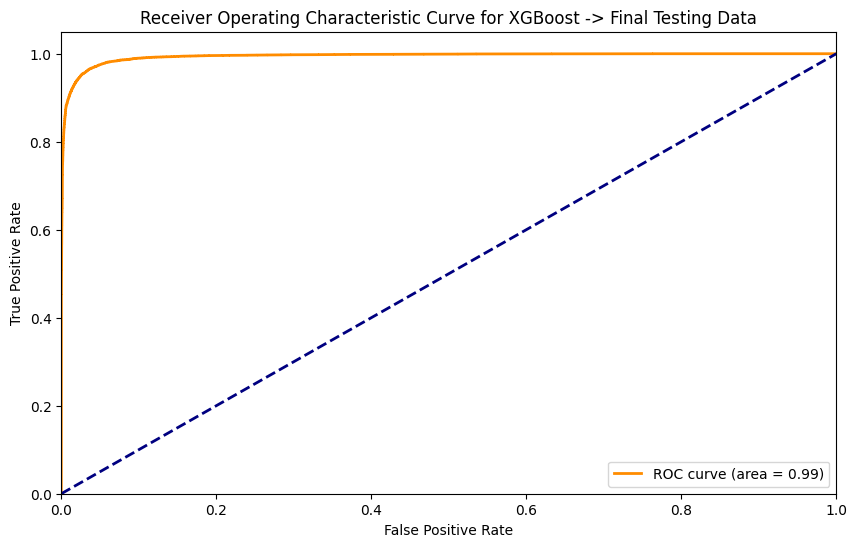

In [ ]:
X_test_embeddings = batch_encode(X_test, model_pretrained)
test_preds = XGBoost_Model.predict(X_test_embeddings)
test_preds_proba = XGBoost_Model.predict_proba(X_test_embeddings)[:, 1]
perform_deep_test_analysis(y_test, test_preds, test_preds_proba, "XGBoost -> Final Testing Data")

## 4.3 Logistic Reg

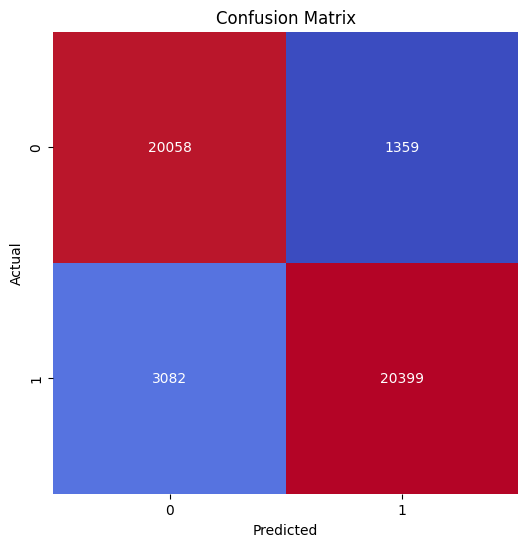



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     21417
           1       0.94      0.87      0.90     23481

    accuracy                           0.90     44898
   macro avg       0.90      0.90      0.90     44898
weighted avg       0.90      0.90      0.90     44898



ROC AUC Score: 90.26%




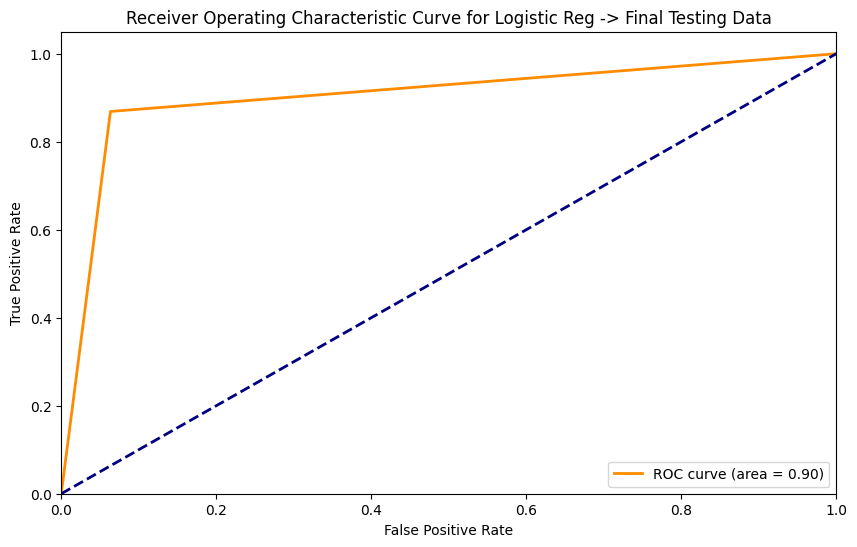

In [ ]:
with open('logisticRegression_Model.pkl', 'rb') as file:
    model = pickle.load(file)

test_preds = model.predict(X_test_embeddings)
test_preds_proba = model.predict_proba(X_test_embeddings)[:, 1]
perform_deep_test_analysis(y_test, test_preds, test_preds, "Logistic Reg -> Final Testing Data")

## 4.4 1d CNN

In [ ]:
class VanillaCNN_1d(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(VanillaCNN_1d, self).__init__()

        self.conv1 = nn.Conv1d(1, 3, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(3)
        self.pool1 = nn.AvgPool1d(2)  # 384 -> 192

        self.conv2 = nn.Conv1d(3, 6, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(6)
        self.pool2 = nn.AvgPool1d(2)  # 192 -> 96

        self.conv3 = nn.Conv1d(6, 8, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(8)
        self.pool3 = nn.AvgPool1d(2)  # 96 -> 48

        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.001)

        # after all pooling layers, we get 8 channels * 48 pixels
        self.fc = nn.Linear(8 * 48, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (Batch, 1, 384)
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))  # (B, 3, 192)
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))  # (B, 6, 96)
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))  # (B, 8, 48)
        x = x.view(x.size(0), -1)  # (B, 8 * 48)
        x = self.dropout(x)
        x = self.fc(x)            # (B, 2)
        return x

cnn = VanillaCNN_1d(384, 2).to(device)
cnn.load_state_dict(torch.load('1d_CNN_Best.pth'))

<All keys matched successfully>

In [ ]:
cnn

VanillaCNN_1d(
  (conv1): Conv1d(1, 3, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2): Conv1d(3, 6, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv3): Conv1d(6, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.001, inplace=False)
  (fc): Linear(in_features=384, out_features=2, bias=True)
)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class EmbeddingDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(np.stack(X), dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
test_ds = EmbeddingDataset(X_test_embeddings, y_test)
test_loader = DataLoader(test_ds, batch_size=batch_size)

100%|██████████| 44/44 [00:00<00:00, 57.30it/s]


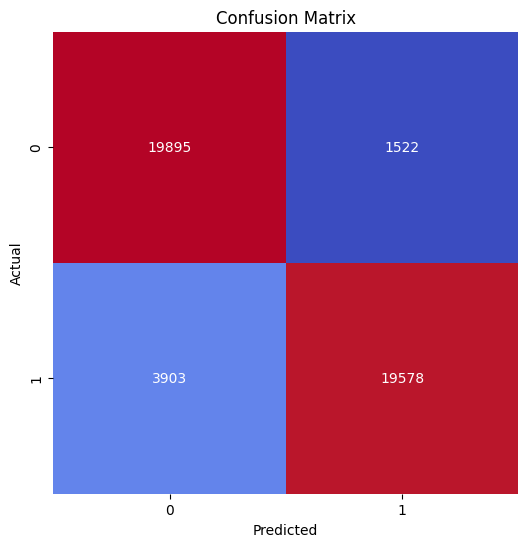



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     21417
           1       0.93      0.83      0.88     23481

    accuracy                           0.88     44898
   macro avg       0.88      0.88      0.88     44898
weighted avg       0.88      0.88      0.88     44898



ROC AUC Score: 95.54%




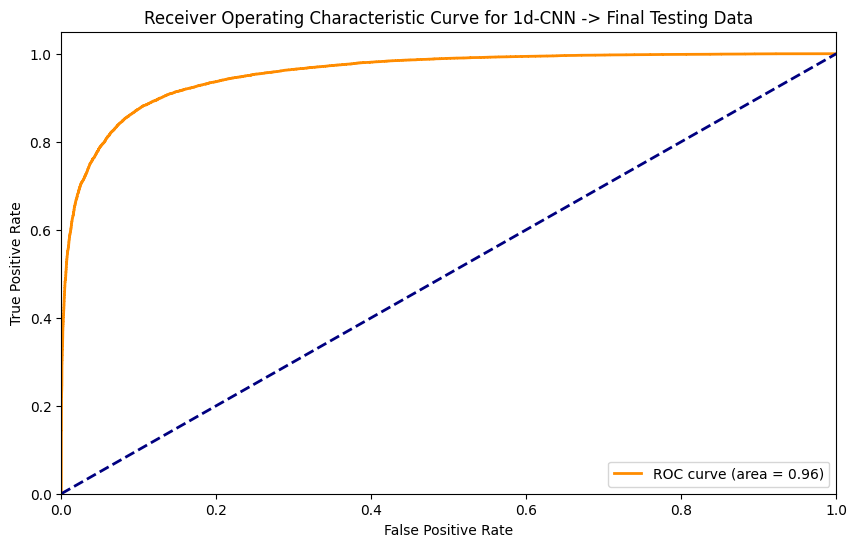

In [ ]:
test_preds, test_probs = make_predictions_using_NN(cnn, test_loader)
perform_deep_test_analysis(y_test, test_preds, test_probs[:, 1], "1d-CNN -> Final Testing Data")

## 4.5 2d CNN

In [ ]:
import torch
import torch.nn as nn

class VanillaCNN_2d(nn.Module):
    def __init__(self, num_classes=2):
        super(VanillaCNN_2d, self).__init__()

        self.conv1 = nn.Conv2d(1, 3, kernel_size=(3,3), padding=1) # input: 1 channel * 16 height * 24 height
        self.bn1 = nn.BatchNorm2d(3)
        self.pool1 = nn.AvgPool2d(2)  # 1 * 16 * 24 -> 3 * 8 * 12

        self.conv2 = nn.Conv2d(3, 6, kernel_size=(3,3), padding=1)
        self.bn2 = nn.BatchNorm2d(6)
        self.pool2 = nn.AvgPool2d(2)  # 3 * 8  * 12 -> 6 * 4 * 6

        self.conv3 = nn.Conv2d(6, 8, kernel_size=(3,3), padding=1)
        self.bn3 = nn.BatchNorm2d(8)
        self.pool3 = nn.AvgPool2d(2)  # 6 * 4 * 6 -> 8 * 2 * 3

        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.001)

        # flattening the 3d array (8 channels * 2 * 3 = 48 input neurons in fully connected layer)
        self.fc = nn.Linear(8 * 2 * 3, num_classes)

    def forward(self, x):
        # Reshape 384 -> 1x16x24 (channel, height, width); this way, it mimics a greyscale image
        x = x.view(-1, 1, 16, 24)
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))  # (B, 3, 8, 12)
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))  # (B, 6, 4, 6)
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))  # (B, 8, 2, 3)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


cnn_2d = VanillaCNN_2d(2).to(device)
cnn_2d.load_state_dict(torch.load('2d_CNN_Best.pth'))

<All keys matched successfully>

100%|██████████| 44/44 [00:00<00:00, 69.13it/s]


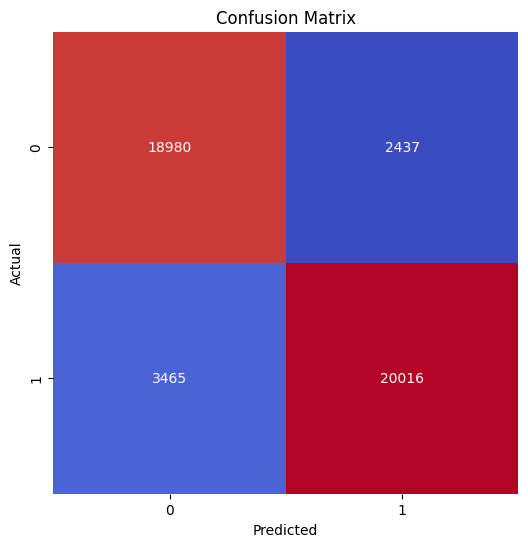



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     21417
           1       0.89      0.85      0.87     23481

    accuracy                           0.87     44898
   macro avg       0.87      0.87      0.87     44898
weighted avg       0.87      0.87      0.87     44898



ROC AUC Score: 94.43%




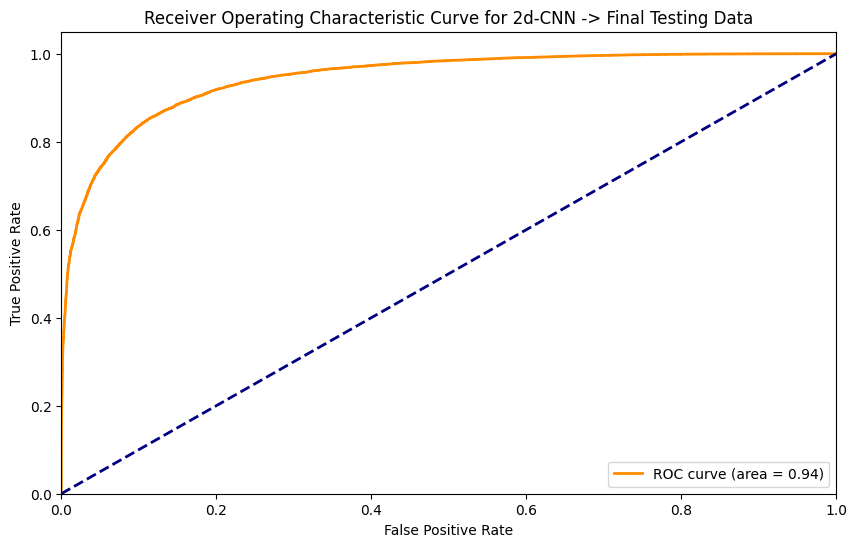

In [ ]:
test_preds, test_probs = make_predictions_using_NN(cnn_2d, test_loader)
perform_deep_test_analysis(y_test, test_preds, test_probs[:, 1], "2d-CNN -> Final Testing Data")

## 4.5 MLP Classifier

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

mlp = SimpleMLP(384, 2).to(device)
mlp.load_state_dict(torch.load('MLP_Best.pth'))

<All keys matched successfully>

100%|██████████| 44/44 [00:00<00:00, 53.00it/s]


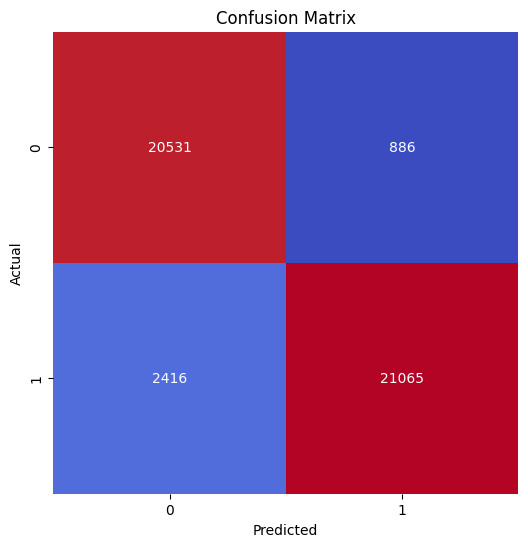



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     21417
           1       0.96      0.90      0.93     23481

    accuracy                           0.93     44898
   macro avg       0.93      0.93      0.93     44898
weighted avg       0.93      0.93      0.93     44898



ROC AUC Score: 98.19%




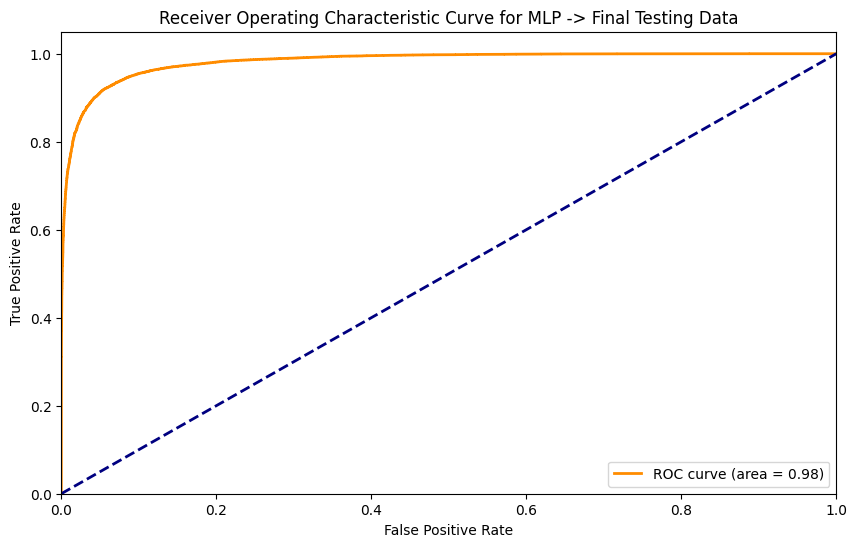

In [ ]:
test_preds, test_probs = make_predictions_using_NN(mlp, test_loader)
perform_deep_test_analysis(y_test, test_preds, test_probs[:, 1], "MLP -> Final Testing Data")

## 4.6 Finetuned EmbeddingClassifier - LORA

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "Real", 1: "Fake"},
    label2id={"Real": 0, "Fake": 1}
)

model = PeftModel.from_pretrained(base_model, "LORA").to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


test_dataset = CustomTextDataset(list(X_test), y_test, tokenizer)

In [17]:
batch_size = 256

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
def make_predictions_using_NN(model, data_loader):
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            # xb = xb.to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            output = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = output.logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    return all_preds, all_probs

In [19]:
test_preds, test_probs = make_predictions_using_NN(model, test_loader)

100%|██████████| 176/176 [04:50<00:00,  1.65s/it]


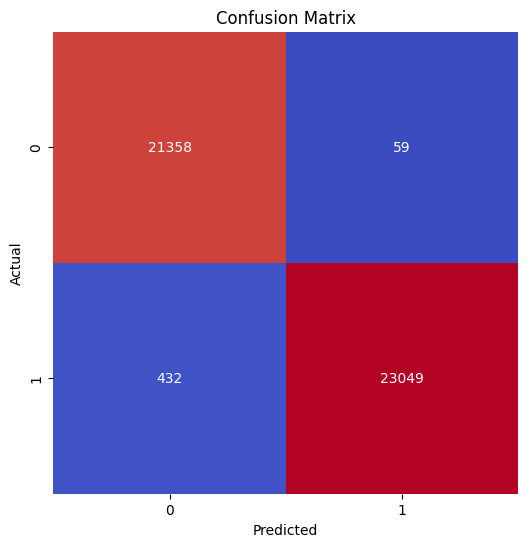



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     21417
           1       1.00      0.98      0.99     23481

    accuracy                           0.99     44898
   macro avg       0.99      0.99      0.99     44898
weighted avg       0.99      0.99      0.99     44898



ROC AUC Score: 99.97%




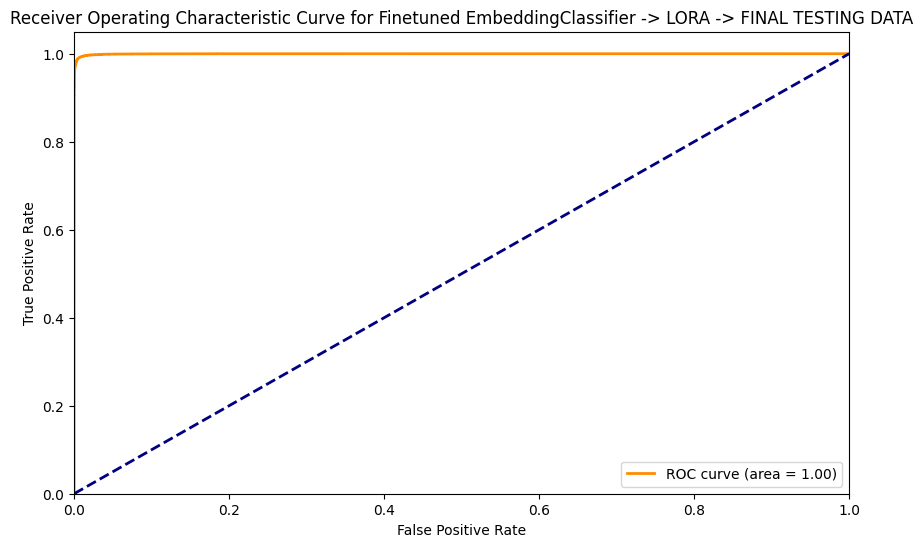

In [24]:
perform_deep_test_analysis(y_test, test_preds, test_probs[:, 1], "Finetuned EmbeddingClassifier -> LORA -> FINAL TESTING DATA")

# 5. Combining All Results


| Model                            | Dataset       | Accuracy | Macro Avg Precision | Macro Avg Recall | Macro Avg F1-Score | ROC AUC |
|:---------------------------------|:--------------|---------:|--------------------:|------------------:|--------------------:|--------:|
| Logistic Regression              | Training      |     0.84 |                0.84 |              0.84 |                0.84 |         |
|                                  | Validation    |     0.84 |                0.84 |              0.84 |                0.84 |         |
|                                  | Test          |     0.84 |                0.84 |              0.84 |                0.84 |  0.9191 |
|                                  | Additional Test |     0.90 |                0.90 |              0.90 |                0.90 |  0.9026 |
| XGBoost                          | Training      |     1.00 |                1.00 |              1.00 |                1.00 |         |
|                                  | Validation    |     0.88 |                0.88 |              0.88 |                0.88 |         |
|                                  | Test          |     0.88 |                0.88 |              0.88 |                0.88 |  0.9527 |
|                                  | Additional Test |     0.96 |                0.96 |              0.96 |                0.96 |  0.9941 |
| 1D-CNN                           | Training      |     0.83 |                0.83 |              0.83 |                0.83 |         |
|                                  | Validation    |     0.81 |                0.81 |              0.81 |                0.81 |         |
|                                  | Test          |     0.82 |                0.82 |              0.82 |                0.82 |  0.9019 |
|                                  | Additional Test |     0.88 |                0.88 |              0.88 |                0.88 |  0.9554 |
| 2D-CNN                           | Training      |     0.81 |                0.81 |              0.81 |                0.81 |         |
|                                  | Validation    |     0.79 |                0.79 |              0.79 |                0.79 |         |
|                                  | Test          |     0.80 |                0.80 |              0.80 |                0.80 |  0.8852 |
|                                  | Additional Test |     0.87 |                0.87 |              0.87 |                0.87 |  0.9443 |
| MLP Classifier                   | Training      |     0.89 |                0.89 |              0.89 |                0.89 |         |
|                                  | Validation    |     0.87 |                0.87 |              0.87 |                0.87 |         |
|                                  | Test          |     0.87 |                0.87 |              0.87 |                0.87 |  0.9442 |
|                                  | Additional Test |     0.93 |                0.93 |              0.93 |                0.93 |  0.9819 |
| Full-Finetuned EmbeddingClassifier | Training      |     0.99 |                0.99 |              0.99 |                0.99 |         |
|                                  | Validation    |     0.96 |                0.96 |              0.96 |                0.96 |         |
|                                  | Test          |     0.96 |                0.96 |              0.96 |                0.96 |  0.9934 |
|                                  | Additional Test |     0.99 |                0.99 |              0.99 |                0.99 |  0.9996 |
